### Scenario description
<br>This scenario illustrates an **autonomous M6 vessel powered by diesel Internal Combustion Engine (ICE) sails an upstream trip from Linz to Regensburg** with real world navigation data where the water depth and current speed vary per waterway stretch. The optimal sailing speed range is selected accordingly with the energy efficiency related indicators, e.g. the amount of emissions (CO2, PM10, NOx), energy consumption, diesel fuel use, fuel cost, with transport time constraints.
###  
### Scenario input
#### (1) vessel information
- autonomous vessel with vessel type CEMT IV, M6 (L: 85m, B: 9.5m, loaded actual draught: 2 m) 
- powered by diesel internal combustion engine, with installed main engine power 780 kW

#### (2) transnational sailing route on the upper Danube
- sailing upstream from Habour Linz (rive-kilometer: 2132 km) to Regensburg (rive-kilometer: 2376 km)
- covering 8 waterway stretches (from west to east): 
<br>Regensburg - lock Straubing - Isar - gauge Vilshofen - lock Kachlet - lock Jochenstein - rkm 2184 - rkm 2147 - harbour Linz
- one-way total distance: 244 km

#### (3) navigation conditions at Low water level (days 181-210 in the year of 2010)
- water depth (m) of the 8 waterway stretches (from west to east): 7.5, 3, 3, 7.5, 7.5, 6.5, 10.6, 5.6
- current speed (km/h) of the 8 waterway stretches (from west to east): 0.8, 2.4, 3.68, 1, 1.5, 1.9, 0.8, 0.7

#### (4) diesel fuel price reference in Europe (average) 
- 1882 EUR / ton (= 1.6 EUR / liter), April 2023

###
#### Simulation Steps
- present all the **waterway stretches** on the graph with navigation conditions. The graph is composed of nodes connected by edges. The navigation conditions are assigned to the edges as 'edge info'.
- define the sailing **path** by specifying the start node and end node. Here we define 8 paths for the 8 stretches to analyse the vessel sailing energy efficiency at each stretch. 
- create the **vessel** with specified dimensions, installed ME power, default sailing speed, sailing direction, ukc safety margin, enable the has_squat function.
- calculate **feasible speed range**: use get_v funtion from OpenTNSim-Energy's 'strategy module' to get maximum feasible velocity considering both installed enegine power and ship squat while moving at a speed for different water depths
- **assign** each of the 8 **paths** to the vessel,
- run the **energy simulation** with feasible speed range input table for each path, output a table with simulation results of all the indicators
- integrate the simulation results table of each path to get an **united table** for the whole route
- use 'Parallel coordinate **plot**' to visualise the united table covering all the possibilities
- show an **example** with transport time constraints and the energy goal


 -----------------
 ##

In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim


In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4366,0],
    [0.8528,0], 
    [1.1443,0],
    [1.31495,0],
    [1.56274,0],
    [1.736384,0],
    [2.0710,0], 
    [2.20665,0],   
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [7.5, 3, 3, 7.5, 7.5, 6.5, 10.6, 5.6]

current_speeds = [-0.8* 0.2777,-2.4* 0.2777,
                  -3.68* 0.2777,-1* 0.2777,
                  -1.5* 0.2777, -1.9* 0.2777,
                  -0.8* 0.2777,-0.7* 0.2777]  # [m/s]


V_g_profile_up = [1,1,1,1,1,1,1,1]

V_g_profile_down = [1,1,1,1,1,1,1,1] # [m/s] for downstream

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

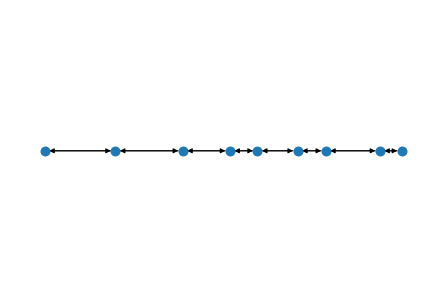

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

In [5]:
path_up_1 = nx.dijkstra_path(FG, nodes[0].name, nodes[1].name)
path_up_2 = nx.dijkstra_path(FG, nodes[1].name, nodes[2].name)
path_up_3 = nx.dijkstra_path(FG, nodes[2].name, nodes[3].name)
path_up_4 = nx.dijkstra_path(FG, nodes[3].name, nodes[4].name)
path_up_5 = nx.dijkstra_path(FG, nodes[4].name, nodes[5].name)
path_up_6 = nx.dijkstra_path(FG, nodes[5].name, nodes[6].name)
path_up_7 = nx.dijkstra_path(FG, nodes[6].name, nodes[7].name)
path_up_8 = nx.dijkstra_path(FG, nodes[7].name, nodes[8].name)

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_up_loaded_LWL = {
    "env": None,
    "name": 'MCV85_9_5_up_loaded_LWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3,
    "use_V_g_profile":None,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 2020, # the engine construction year is only used for diesel use and emissions quantification
}             



In [8]:


# create lists of strategy values
T_strategy = [2]
h_min = [7.5, 3, 3, 7.5, 7.5, 6.5, 10.6, 5.6]
safety_margin = [0.3]
width = [200]


In [9]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product( h_min,T_strategy, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"h_min": item[0],"T_strategy":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(20)

,h_min,T_strategy,safety_margin,width
0,7.5,2,0.3,200
1,3.0,2,0.3,200
2,3.0,2,0.3,200
3,7.5,2,0.3,200
4,7.5,2,0.3,200
5,6.5,2,0.3,200
6,10.6,2,0.3,200
7,5.6,2,0.3,200


In [10]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):

    # get vessel 
    data_vessel_i = data_vessel_MCV85_9_5_up_loaded_LWL.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_strategy']
    vessel.safety_margin = row['safety_margin']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = opentnsim.strategy.get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h_min'], margin=0)
    
    # calculate the velocity that belongs to the T_strategy (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = opentnsim.strategy.get_v(vessel, width=row['width'], depth=row['h_min'], margin=row['safety_margin'], bounds=(0, upperbound))
    

    
    Strategy ={}
    Strategy.update(row)
    # Strategy['v_upper_bound (m/s)'] = upperbound # power allowed max v   
    Strategy['v_strategy (m/s)'] = v  # final max v considering squat and installed power
    Strategy['z_computed (m)'] = z_computed    
    
    Strategies.append(Strategy)

h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h_0/T is too small to sail
h

In [11]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df)

,h_min,T_strategy,safety_margin,width,v_strategy (m/s),z_computed (m)
0,7.50,2.00,0.30,200.00,5.06,0.14
1,3.00,2.00,0.30,200.00,3.93,0.18
2,3.00,2.00,0.30,200.00,3.93,0.18
3,7.50,2.00,0.30,200.00,5.06,0.14
4,7.50,2.00,0.30,200.00,5.06,0.14
5,6.50,2.00,0.30,200.00,4.86,0.15
6,10.60,2.00,0.30,200.00,5.26,0.12
7,5.60,2.00,0.30,200.00,4.86,0.17


#### Advanced Parallel Coordinates Plot

In [12]:
strategies_df = df2

NameError: name 'df2' is not defined

In [ ]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = strategies_df['T_strategy'],
                   colorscale = 'Electric',
                   # colorscale = 'armyrose',
                   showscale = True,
                   cmin = 6,
                   cmax = 15),
        dimensions = list([
            dict(range = [3000,35000],
                 visible = True,
                 label = 'load_volume (m3)', values = strategies_df['load_volume']),
            dict(tickvals = [6,7,8,9,10,11,12,13,14],
                 ticktext = ['6','7','8','9','10','11','12','13','14'],
                 label = "T (m)", values = strategies_df['T_strategy']),
           
            dict(range = [1,10],
                 # constraintrange = [2,3.5],
                 label = "Feasible SL Velocities (m/s)", values = strategies_df['v_feasible']),                       

            dict(range = [0,25000],
                 label = 'total CO2 (ton)', values = strategies_df['total CO2 (ton)']),
            dict(range = [0,20],                
                 label = 'total PM10 (ton)', values = strategies_df['total PM10 (ton)']),
            dict(range = [0,800],                 
                 label = 'total NOX (ton)', values = strategies_df['total NOX (ton)']),
            dict(range = [100,10000],
                 # constraintrange = [8,20],
                 label = 'total fuel use (ton)', values = strategies_df['total fuel use (ton)']),
            dict(range = [0,30],                 
                 label = 'total time (weeks)', values = strategies_df['total time (weeks)']),
            dict(range = [0,1500],
                 # constraintrange = [8,20],
                 label = 'total_cost (million USD)', values = strategies_df['total_cost_load_unload_SL']),            
           
        ]),
    )
)
fig.show()